Steps to follow 
===
1) Question or problem definition.
--
2) Acquire training and testing data. 
--
3) Wrangle, prepare, cleanse the data.
--
4) Analyze, identify patterns, and explore the data.
--
5) Model, predict and solve the problem.
--
6) Visualize, report, and present the problem solving steps and final solution.
--

I Question & Problem Definition
==
We want to create a trading bot which can make decisions : BUY / SELL / HOLD (Classification problem). <br>
To do this we have previously created a database (.csv file) in which we have put different indicators. <br>
With those indicators we expect to be able to predict this decision. <br>
We need to create a pertinent label to predict. <br>
To know : on GDAX the fee on each transaction is 0.3%. <br>

First naive label
--
-1 on each chandelier on which we have a decrease of at least 0.3% <br>
+1 on each chandelier on which we have a increase of at least 0.3% <br>
0 if between -0.3 and 0.3% <br>

Second label (rolling window)
--
We are creating a list with the first 24 values of the dataset, if the first value of this list is the minimum or the maximum
of the list we have to buy (if minimum) or to sell (if maximum), if this is not a max or a min we just hold. Then we are moving
of one step, the following list is from the second value to the 25th value and we do the same process. <br>
This is going to allow us to see trends with our label. <br>

Third label binarization
--
The problem with this label is that there are not enough 1 and -1 (buy or sell action), so our ML is not going to be the most
efficient to detect those actions. So what we do is that we are changing all the 0 by 1 and -1. If we are on a high trend 
(between a 1 and a -1) all the zeros will become 1, during a down trend, there are becoming a -1.





II Acquire training and testing data
===
We have done all those steps in another algorithm which is giving us a csv file ouput. <br>
Note : In our dataset we have already solved the problem of NaN values.

III Wrangle, prepare, cleanse the data
===
Once we have import our csv file, we need to create some features that could be useful to our study. <br>

First step
----
We are transforming our first dataset to have new interesting features

In [1]:
import pandas as pd
import numpy as np
import results
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-poster')

file_name = 'btc_eur_3600.csv'
df_primary = pd.read_csv(r'C:\Users\flore\.spyder-py3\trading_bot\btc_eur_3600_290418.csv')


# Normalisation
# This allows to have all our data on the same scale. To this end it is relevant to compare different chandelier together

df_primary['bdb_high_n'] = df_primary['bdb_high'] / df_primary['opening_price']
df_primary['bdb_low_n'] = df_primary['bdb_low'] / df_primary['opening_price']
df_primary['high_price_n'] = df_primary['high_price'] / df_primary['opening_price']
df_primary['low_price_n'] = df_primary['low_price'] / df_primary['opening_price']
df_primary['macd_n'] = df_primary['macd'] / df_primary['opening_price']
df_primary['macd_derivative_n'] = df_primary['macd_n'] - df_primary['macd_n'].shift(1)
df_primary['variation'] = (df_primary['closing_price'] - df_primary['opening_price']) / df_primary['opening_price'] * 100


df_primary['macd-1'] = df_primary['macd_n'].shift(1)
df_primary['macd-2'] = df_primary['macd_n'].shift(2)
df_primary['macd-3'] = df_primary['macd_n'].shift(3)

df_primary['var-1'] = df_primary['variation'].shift(1)
df_primary['var-2'] = df_primary['variation'].shift(2)

# MACD is one of the most important indicator in stock prices classic analysis, we are creating its derivate, and its 
# second derivate to see if there is a correlation with the stock prices
df_primary['macd_second_derivative_n'] = df_primary['macd_derivative_n'] - df_primary['macd_derivative_n'].shift(1)
df_primary['macd_historic'] = df_primary['macd_n'] + df_primary['macd_n'].shift(2)
df_primary['product_macd'] = df_primary["macd_n"]*df_primary['macd_derivative_n']

# Volatility
df_primary['volatility'] = df_primary['high_price_n'] - df_primary['low_price_n']
df_primary['derivate_volatility'] = df_primary['volatility'] - df_primary['volatility'].shift(1)
df_primary['derivate_volume'] = df_primary['volume'] - df_primary['volume'].shift(1)

# Stochastique
df_primary['stochastic_derivative'] = df_primary['stochastic'] - df_primary['stochastic'].shift(1)
df_primary['product_stochastic'] = df_primary["stochastic"]*df_primary['stochastic_derivative']
# Redudancy variables dropped
cols = ['bdb_high_n', 'bdb_low_n', 'macd_n', 'macd_derivative_n', 'closing_price', 'variation', 'opening_price', 
        'high_price_n', 'low_price_n', 'macd-1', 'macd-2', 'macd-3', 'var-1','var-2', 'macd_second_derivative_n',
       'product_macd', 'volatility', 'derivate_volatility', 'derivate_volume', 'stochastic_derivative', 'product_stochastic','macd_historic']
df_primary = df_primary[cols]

#import Qualitative_strategies
#
#df_primary['bdb_high_decision'] =  df_primary.apply(Qualitative_strategies.bdb_high, axis = 1)
#df_primary['bdb_low_decision'] =  df_primary.apply(Qualitative_strategies.bdb_low, axis = 1)
#df_primary['macd_decision'] = df_primary.apply(Qualitative_strategies.macd, axis = 1)
#df_primary['decision_vector'] = df_primary.apply(Qualitative_strategies.decision_vector, axis = 1)
#
df_primary['closing_price'] = df_primary['closing_price'].shift(1)
beggining_test = 4000
df_test = df_primary.loc[beggining_test + 1:]

df_train = df_primary.loc[:beggining_test]
df_train.tail()
df_test.head()

,bdb_high_n,bdb_low_n,macd_n,macd_derivative_n,closing_price,variation,opening_price,high_price_n,low_price_n,macd-1,...,var-1,var-2,macd_second_derivative_n,product_macd,volatility,derivate_volatility,derivate_volume,stochastic_derivative,product_stochastic,macd_historic
4001,0.982143,0.945192,0.012459,0.000439,8157.44,-0.254492,8157.44,1.014534,0.988055,0.012020,...,2.217154,0.512481,-0.001028,5.464136e-06,0.026479,-0.002554,173.678322,-0.590792,-0.209731,0.023013
4002,0.989584,0.950364,0.013114,0.000656,8136.68,0.717689,8131.66,1.010864,0.999181,0.012459,...,-0.254492,2.217154,0.000217,8.600315e-06,0.011683,-0.014796,-396.384024,0.329421,0.225463,0.025135
4003,0.985326,0.948244,0.013080,-0.000034,8190.02,-0.259462,8190.02,1.002317,0.986740,0.013114,...,0.717689,-0.254492,-0.000690,-4.447812e-07,0.015577,0.003895,-26.575494,0.000247,0.000169,0.025539
4004,0.987891,0.955826,0.011305,-0.001776,8168.77,-2.393427,8167.37,1.000000,0.973386,0.013080,...,-0.259462,0.717689,-0.001742,-2.007262e-05,0.026614,0.011037,55.561956,-0.583965,-0.058807,0.024419
4005,1.014290,0.981543,0.011453,0.000148,7971.89,1.866187,7971.87,1.025031,0.998611,0.011305,...,-2.393427,-0.259462,0.001924,1.695600e-06,0.026419,-0.000195,-137.845661,0.658234,0.499559,0.024533


Second Step
--
We are creating the label

In [2]:
# Trend Label, which is rolling on a 24h window and put a 1 (buy) or a -1 (sell) when we are on the maximum of those 24 hours    
# 0 if this is not a maximum. 3-classes classification
def local_extrema_label(window_array):
    if window_array[0] == max(window_array):
        return -1
    elif window_array[0] == min(window_array):
        return 1
    else:
        return 0   

    
def label(data_row, seuil = 0.3):        
    variation = data_row['variation']    
    if variation >= seuil:
        return 1
    elif variation <= - seuil:
        return -1
    else:
        return 0 

window_length = 12

df_train['label_trend_3_classes'] = df_train['closing_price'].rolling(window=window_length,center=False
                                ).apply(func=local_extrema_label
                                ).shift(-window_length+1)

df_train['label_basique'] = df_train.apply(label, axis=1)

label = df_train['label_trend_3_classes'].values.tolist()
new_label = []
high_trend = True

#binarization

for i in range(len(label)):

    if label[i] in (0,1) and high_trend:
        new_label.append(1)
    elif label[i] == -1 and high_trend:
        high_trend = False
        new_label.append(0)

    elif label[i] in (0,-1) and not high_trend:
        new_label.append(0)
    elif label[i] == 1 and not high_trend:
        high_trend = True
        new_label.append(1)

df_train = pd.concat([df_train, pd.DataFrame(new_label, columns = ['label_trend_2_classes'])], axis = 1)
df_train.dropna(inplace=True)    
df_train_label = df_train['label_trend_2_classes']
df_train.tail()


C:\Users\flore\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\flore\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,bdb_high_n,bdb_low_n,macd_n,macd_derivative_n,closing_price,variation,opening_price,high_price_n,low_price_n,macd-1,...,product_macd,volatility,derivate_volatility,derivate_volume,stochastic_derivative,product_stochastic,macd_historic,label_trend_3_classes,label_basique,label_trend_2_classes
3984,1.005259,0.958731,0.014259,-0.001293,7559.00,0.291969,7559.01,1.007369,0.999999,0.015552,...,-0.000018,0.007370,-0.005971,-62.075225,0.396338,0.157084,0.031461,1.0,0,1.0
3985,1.006563,0.960490,0.014993,0.000735,7581.08,2.439362,7581.08,1.027690,0.999999,0.014259,...,0.000011,0.027691,0.020321,77.658668,0.484622,0.426933,0.030545,1.0,1,1.0
3986,0.986606,0.941066,0.014711,-0.000282,7766.01,0.097734,7766.01,1.005664,0.997327,0.014993,...,-0.000004,0.008338,-0.019354,3.384757,-0.443122,-0.194016,0.028970,1.0,0,1.0
3987,0.989827,0.943128,0.015653,0.000942,7773.60,1.205550,7780.68,1.012372,0.998095,0.014711,...,0.000015,0.014276,0.005939,-18.924567,0.540016,0.528057,0.030646,1.0,1,1.0
3988,0.981724,0.937414,0.015908,0.000255,7874.48,-0.120008,7874.48,1.000701,0.991631,0.015653,...,0.000004,0.009070,-0.005207,40.627264,-0.187459,-0.148167,0.030620,0.0,0,1.0


Testing set label
---
Because of pandas implementation (and lack of knowledge about it), we have to redo the label definition with lists for the testing set

In [3]:
close = df_test['closing_price'].values.tolist()

target = []

for i in range(len(close)):
    sous_close = close[i:i+window_length]
    if sous_close[0] == min(sous_close):
        target.append(1)
    elif sous_close[0] == max(sous_close):
        target.append(-1)
    else:
        target.append(0)
        
final_target = []
high_trend = True

for i in range(len(target)):

    if target[i] in (0,1) and high_trend:
        final_target.append(1)
    elif target[i] == -1 and high_trend:
        high_trend = False
        final_target.append(0)

    elif target[i] in (0,-1) and not high_trend:
        final_target.append(0)
    elif target[i] == 1 and not high_trend:
        high_trend = True
        final_target.append(1)
        
#check sizes
        
if len(final_target) != len(df_test):
    print('ERROR, X_test and y_test have different sizes')

# Name consistency
df_test_label = final_target


Dataframes cleaning & market prices list creation
--

In [4]:
#Useful to plot our results later with the X_test
market_prices = df_test['variation'].values.tolist()
market_var = results.buy_hold_results(market_prices)

#features selection
def feature_selection(df):
    cols = ['bdb_high_n', 'bdb_low_n', 'macd_n', 'macd_derivative_n',
           'high_price_n', 'low_price_n', 'macd-1', 'macd-2', 'macd-3',
           'var-1', 'var-2', 'macd_second_derivative_n', 'product_macd',
           'volatility', 'derivate_volatility', 'derivate_volume',
           'stochastic_derivative', 'product_stochastic']
    return(df[cols])
#'macd_historic','decision_vector']
#       'bdb_high_decision', 'bdb_low_decision', 'macd_decision', '
df_test_features = feature_selection(df_test)

df_train_features = feature_selection(df_train)

df_test_features.head()

,bdb_high_n,bdb_low_n,macd_n,macd_derivative_n,high_price_n,low_price_n,macd-1,macd-2,macd-3,var-1,var-2,macd_second_derivative_n,product_macd,volatility,derivate_volatility,derivate_volume,stochastic_derivative,product_stochastic
4001,0.982143,0.945192,0.012459,0.000439,1.014534,0.988055,0.012020,0.010554,0.010836,2.217154,0.512481,-0.001028,5.464136e-06,0.026479,-0.002554,173.678322,-0.590792,-0.209731
4002,0.989584,0.950364,0.013114,0.000656,1.010864,0.999181,0.012459,0.012020,0.010554,-0.254492,2.217154,0.000217,8.600315e-06,0.011683,-0.014796,-396.384024,0.329421,0.225463
4003,0.985326,0.948244,0.013080,-0.000034,1.002317,0.986740,0.013114,0.012459,0.012020,0.717689,-0.254492,-0.000690,-4.447812e-07,0.015577,0.003895,-26.575494,0.000247,0.000169
4004,0.987891,0.955826,0.011305,-0.001776,1.000000,0.973386,0.013080,0.013114,0.012459,-0.259462,0.717689,-0.001742,-2.007262e-05,0.026614,0.011037,55.561956,-0.583965,-0.058807
4005,1.014290,0.981543,0.011453,0.000148,1.025031,0.998611,0.011305,0.013080,0.013114,-2.393427,-0.259462,0.001924,1.695600e-06,0.026419,-0.000195,-137.845661,0.658234,0.499559


PCA bloc
--
Because of the redudancy between our variables, we are reducing the dimensions of our dataset with this technique

In [5]:
import pickle

X_test = np.array(df_test_features)
y_test = np.array(df_test_label)
X_train = np.array(df_train_features)
y_train = np.array(df_train_label)

from sklearn.preprocessing import StandardScaler

# StandardScaler creation and fitting
scaler = StandardScaler()
scaler.fit(X_train)

# Classic StandardScaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.decomposition import PCA

# PCA creation and fitting
pca = PCA(0.95)
pca = pca.fit(X_train)

# Classic PCA
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

print(X_train.shape, X_test.shape, y_train.shape,  y_test.shape)



(3986, 9) (1725, 9) (3986,) (1725,)


In [6]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=10, max_iter=1000, random_state=0)
clf = clf.fit(X_train, y_train)

score_test = clf.score(X_test, y_test)
score_train = clf.score(X_train, y_train)

print(score_train, score_test)

predictions = clf.predict(X_test).tolist()
for i in range(len(predictions)):
    if predictions[i] == 0.0:
        predictions[i] = -1
labels = y_test.tolist()
for i in range(len(y_test)):
    if labels[i] == 0.0:
        labels[i] = -1
        
#results.plot_strategy_with_labels(labels, predictions, market_var, notebook=True)
results.plot_strategy(predictions, market_var, notebook=True)


0.66256899147 0.729275362319


Loading BokehJS ...

Comparison of different Machine Learning Algorithms
--
Here we are testing the most common Machine learning algorithms <br>
This will return during each steps the best model

Il reste 20 algorithmes à exécuter.
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=500, random_state=None)
Aggregated results are:
Hold         : 785
Buy          : 266
Sell         : 265
Got_cash     : 675
Fees_cost    : 396.3581874619883% of initial investment
Total_result : +312.6439768984194% from initial investment


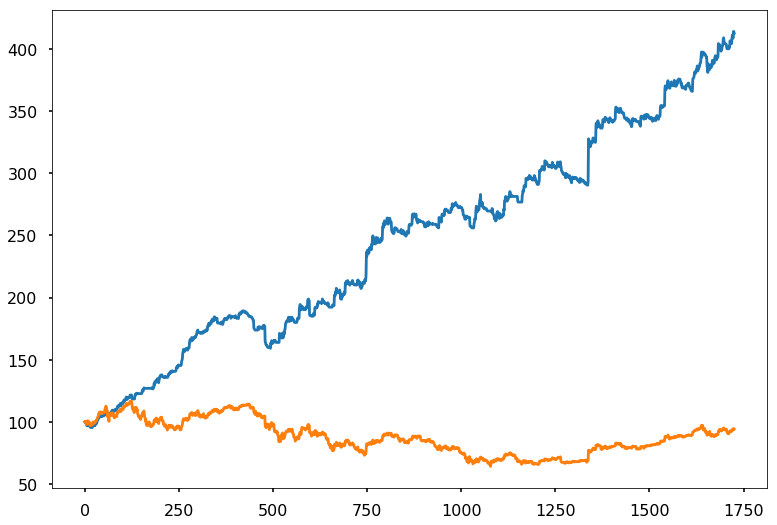

Il reste 19 algorithmes à exécuter.
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)
Aggregated results are:
Hold         : 591
Buy          : 293
Sell         : 292
Got_cash     : 842
Fees_cost    : 351.60187492039984% of initial investment
Total_result : +151.86651953049267% from initial investment


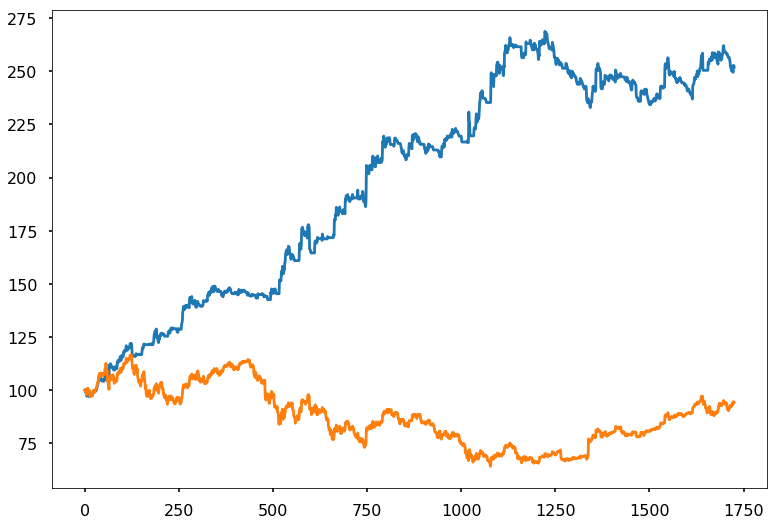

Il reste 18 algorithmes à exécuter.
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Aggregated results are:
Hold         : 813
Buy          : 208
Sell         : 207
Got_cash     : 705
Fees_cost    : 569.3689786082011% of initial investment
Total_result : +924.3007941750184% from initial investment


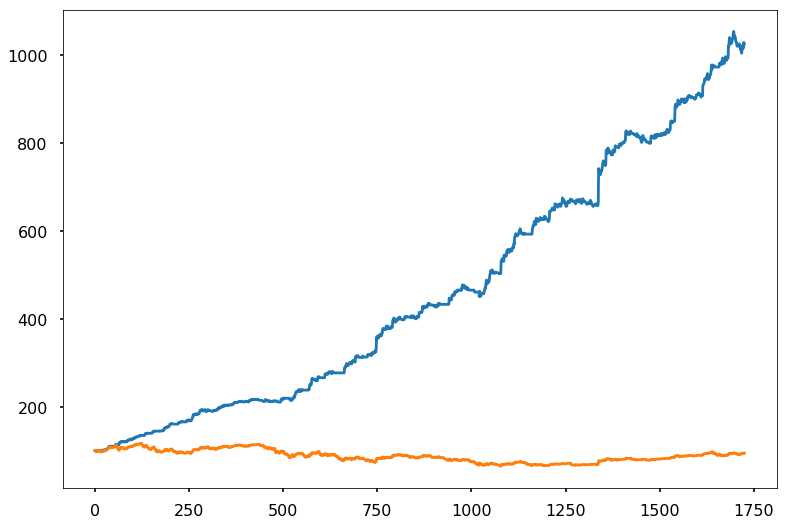

Il reste 17 algorithmes à exécuter.
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Aggregated results are:
Hold         : 747
Buy          : 241
Sell         : 240
Got_cash     : 738
Fees_cost    : 353.28483922150497% of initial investment
Total_result : +338.96406243776505% from initial investment


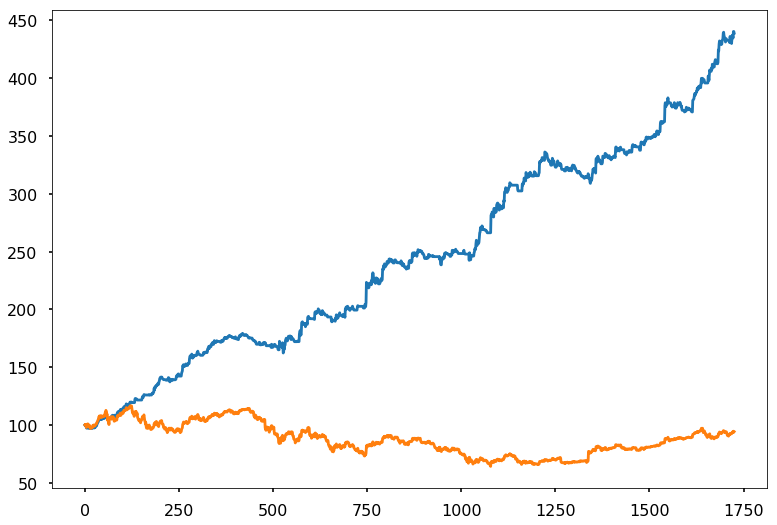

Il reste 16 algorithmes à exécuter.
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Aggregated results are:
Hold         : 789
Buy          : 212
Sell         : 211
Got_cash     : 725
Fees_cost    : 576.2005857770674% of initial investment
Total_result : +859.9044099447982% from initial investment


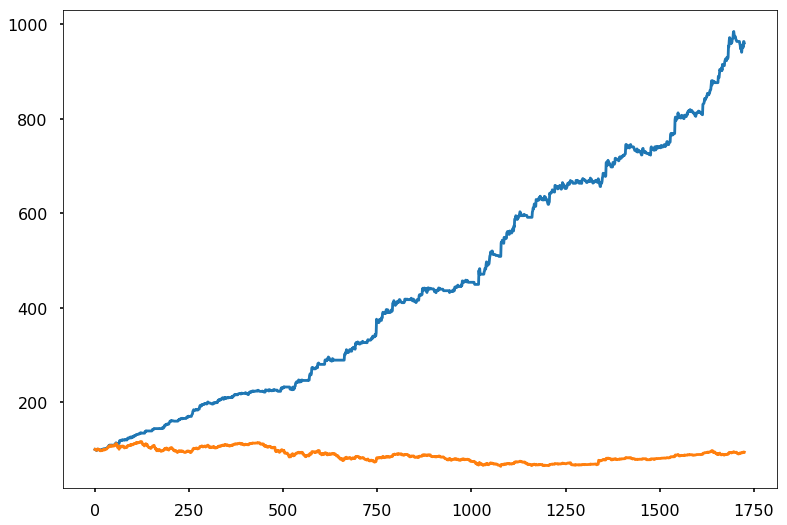

Il reste 15 algorithmes à exécuter.
LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)
Aggregated results are:
Hold         : 981
Buy          : 160
Sell         : 159
Got_cash     : 585
Fees_cost    : 536.2794956762228% of initial investment
Total_result : +1638.2908756978252% from initial investment


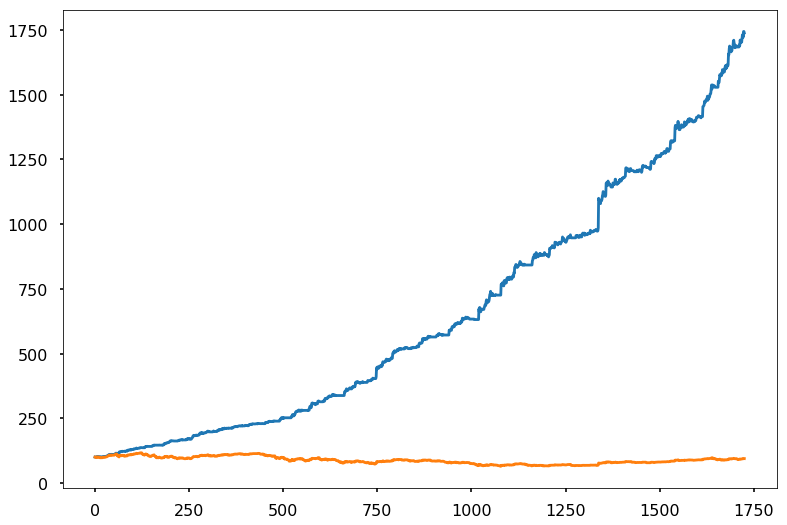

Il reste 14 algorithmes à exécuter.
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=1000, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=0.001,
              verbose=0, warm_start=False)
Aggregated results are:
Hold         : 899
Buy          : 211
Sell         : 210
Got_cash     : 616
Fees_cost    : 88.06315603619858% of initial investment
Total_result : -48.253482371806896% from initial investment


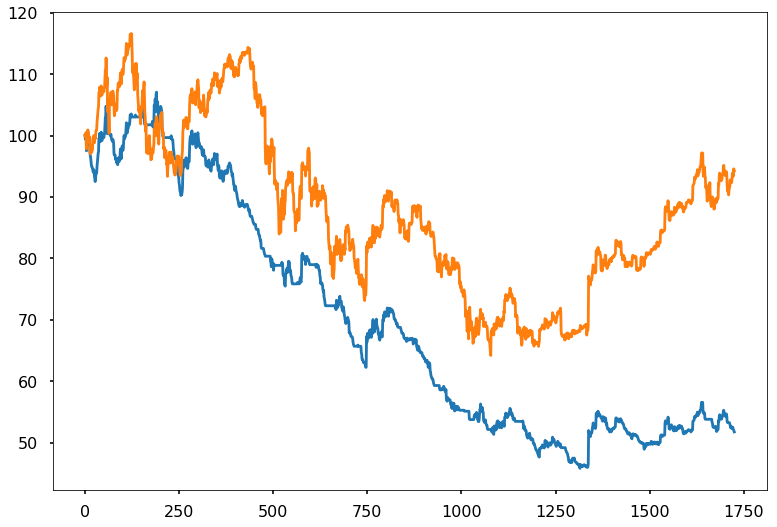

Il reste 13 algorithmes à exécuter.
RidgeClassifierCV(alphas=(0.1, 1.0, 10.0), class_weight=None, cv=None,
         fit_intercept=True, normalize=False, scoring=None)
Aggregated results are:
Hold         : 1017
Buy          : 156
Sell         : 155
Got_cash     : 553
Fees_cost    : 503.6059608892815% of initial investment
Total_result : +1637.5428807188957% from initial investment


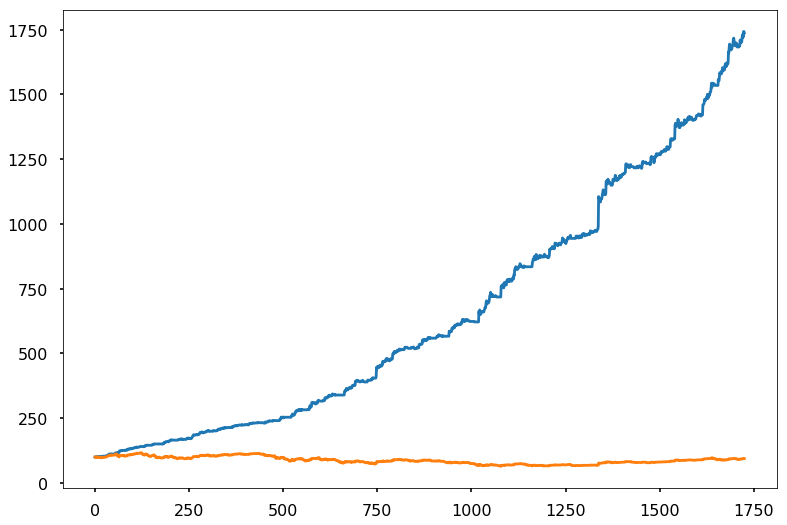

Il reste 12 algorithmes à exécuter.
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
Aggregated results are:
Hold         : 1007
Buy          : 131
Sell         : 130
Got_cash     : 588
Fees_cost    : 161.47608613654756% of initial investment
Total_result : +278.3610279426854% from initial investment


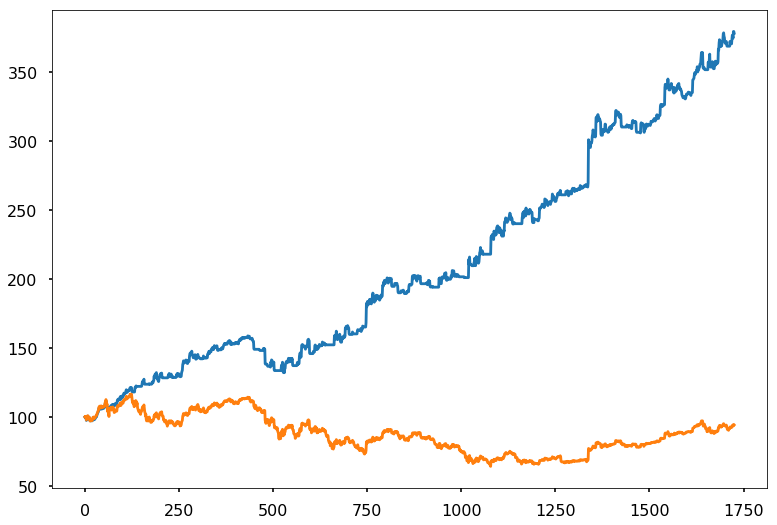

Il reste 11 algorithmes à exécuter.
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=1000, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=0.001, verbose=0, warm_start=False)
Aggregated results are:
Hold         : 585
Buy          : 257
Sell         : 257
Got_cash     : 883
Fees_cost    : 176.49663210258083% of initial investment
Total_result : +22.232081672790997% from initial investment


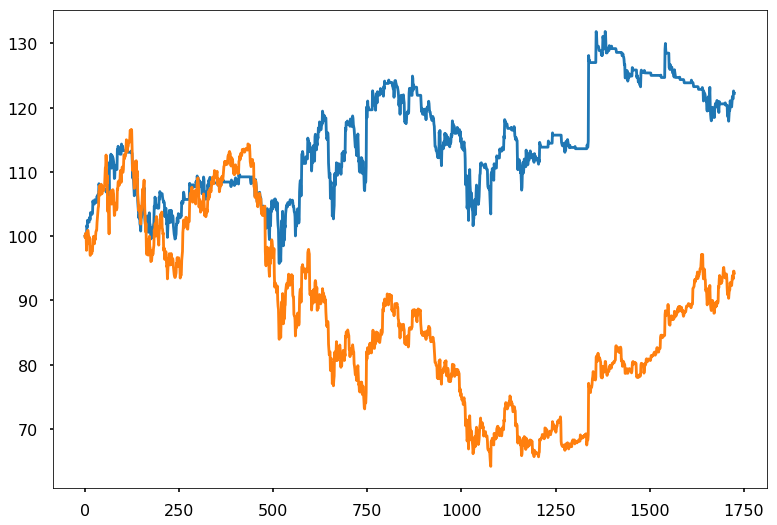

Il reste 10 algorithmes à exécuter.
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Aggregated results are:
Hold         : 732
Buy          : 256
Sell         : 255
Got_cash     : 738
Fees_cost    : 412.91329639262875% of initial investment
Total_result : +390.05433133536974% from initial investment


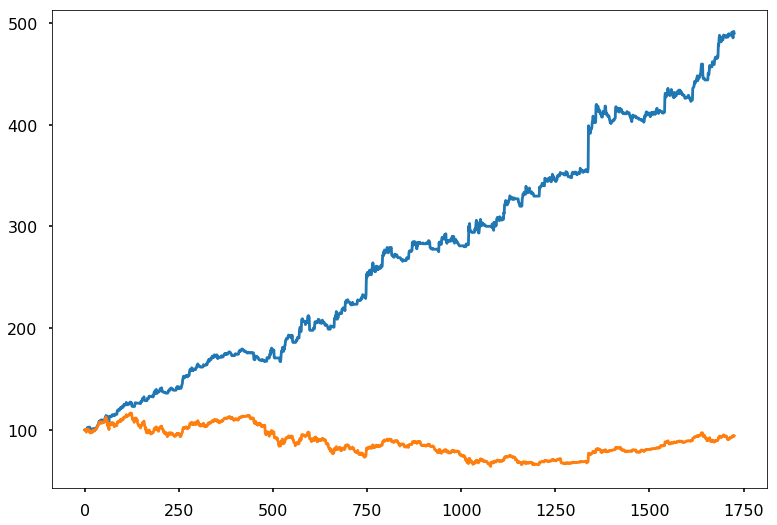

Il reste 9 algorithmes à exécuter.
GaussianNB(priors=None)
Aggregated results are:
Hold         : 1312
Buy          : 125
Sell         : 124
Got_cash     : 289
Fees_cost    : 217.8097294885092% of initial investment
Total_result : +651.9936462250248% from initial investment


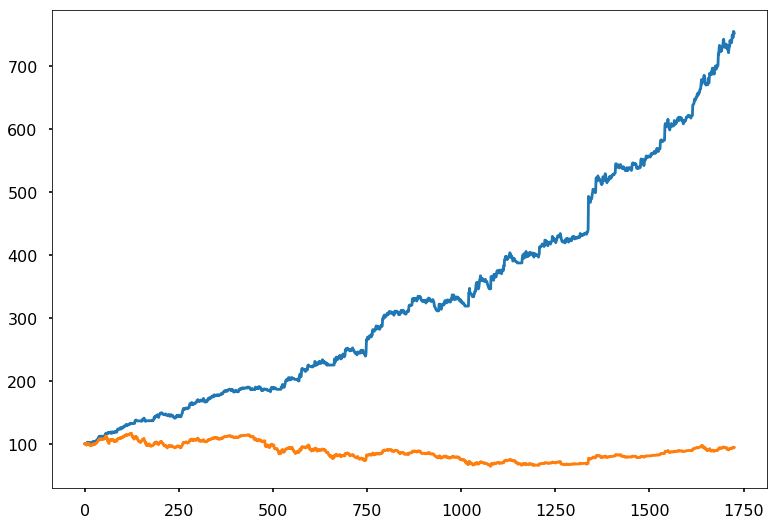

Il reste 8 algorithmes à exécuter.
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Aggregated results are:
Hold         : 705
Buy          : 285
Sell         : 284
Got_cash     : 736
Fees_cost    : 412.2724552795599% of initial investment
Total_result : +282.54252694847077% from initial investment


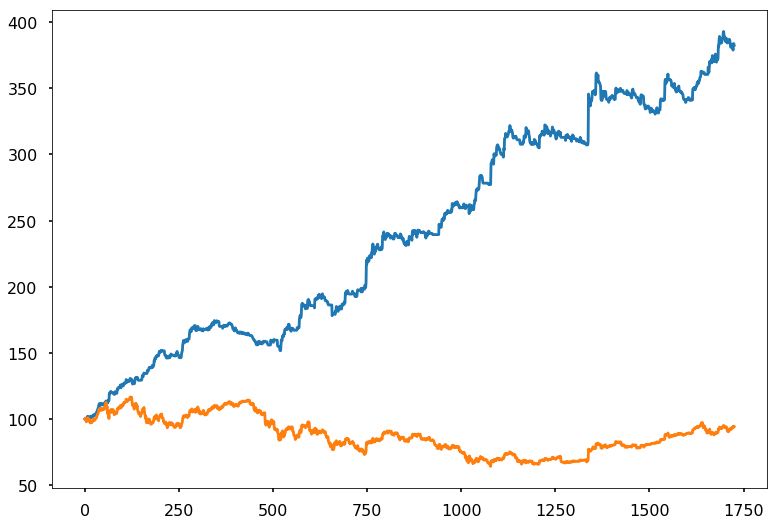

Il reste 7 algorithmes à exécuter.
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Aggregated results are:
Hold         : 870
Buy          : 185
Sell         : 184
Got_cash     : 671
Fees_cost    : 522.5959187529622% of initial investment
Total_result : +1073.1277503722322% from initial investment


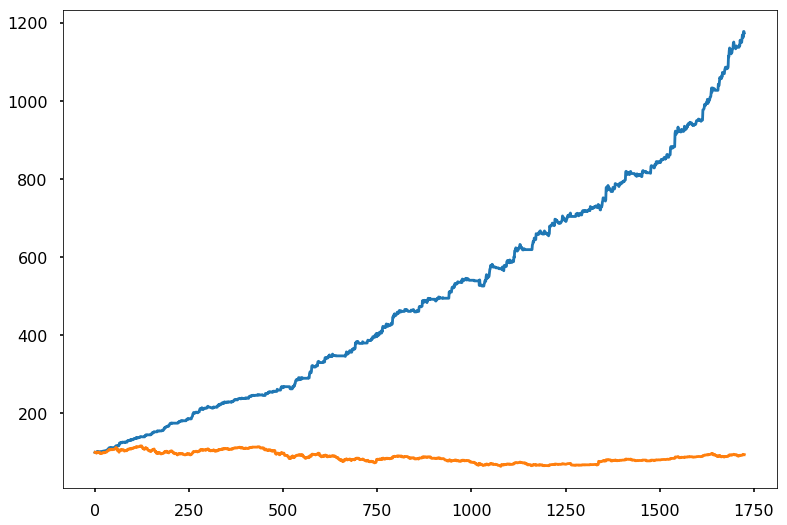

Il reste 6 algorithmes à exécuter.
NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, nu=0.5, probability=True, random_state=None,
   shrinking=True, tol=0.001, verbose=False)
Aggregated results are:
Hold         : 763
Buy          : 241
Sell         : 240
Got_cash     : 722
Fees_cost    : 268.2840085677417% of initial investment
Total_result : +182.55614702453033% from initial investment


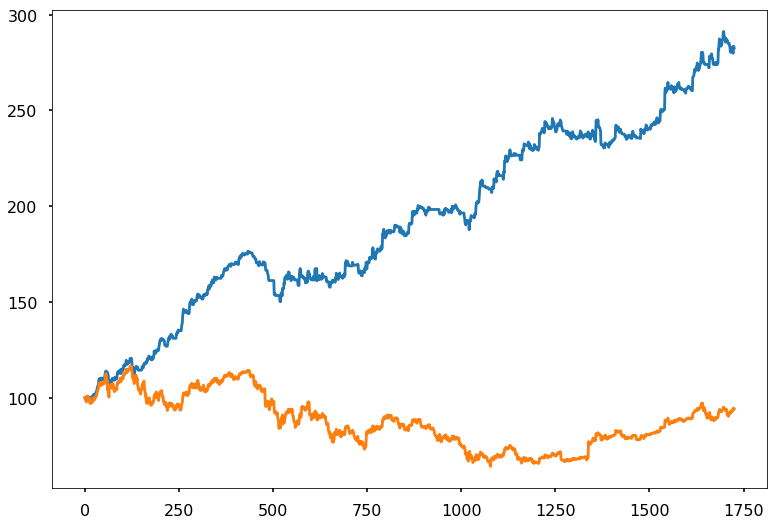

Il reste 5 algorithmes à exécuter.
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Aggregated results are:
Hold         : 1020
Buy          : 153
Sell         : 152
Got_cash     : 553
Fees_cost    : 490.98078638591596% of initial investment
Total_result : +1606.0450394517568% from initial investment


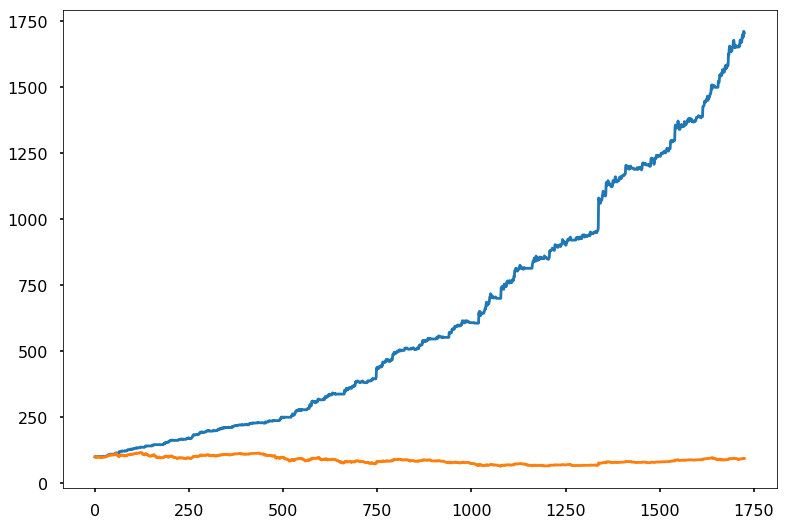

Il reste 4 algorithmes à exécuter.
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Aggregated results are:
Hold         : 536
Buy          : 397
Sell         : 396
Got_cash     : 793
Fees_cost    : 189.83967572154535% of initial investment
Total_result : -45.56969922993789% from initial investment


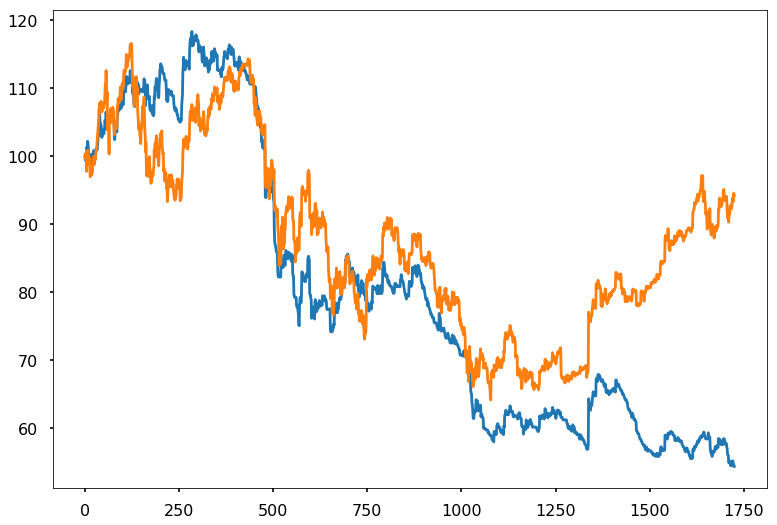

Il reste 3 algorithmes à exécuter.
ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')
Aggregated results are:
Hold         : 538
Buy          : 386
Sell         : 385
Got_cash     : 802
Fees_cost    : 201.03092707928673% of initial investment
Total_result : -31.998104335769497% from initial investment


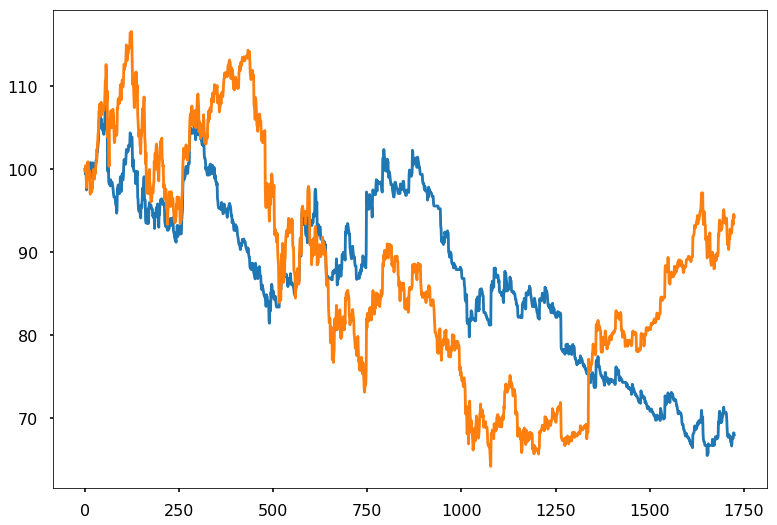

Il reste 2 algorithmes à exécuter.
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
Aggregated results are:
Hold         : 1017
Buy          : 156
Sell         : 155
Got_cash     : 553
Fees_cost    : 503.6059608892815% of initial investment
Total_result : +1637.5428807188957% from initial investment


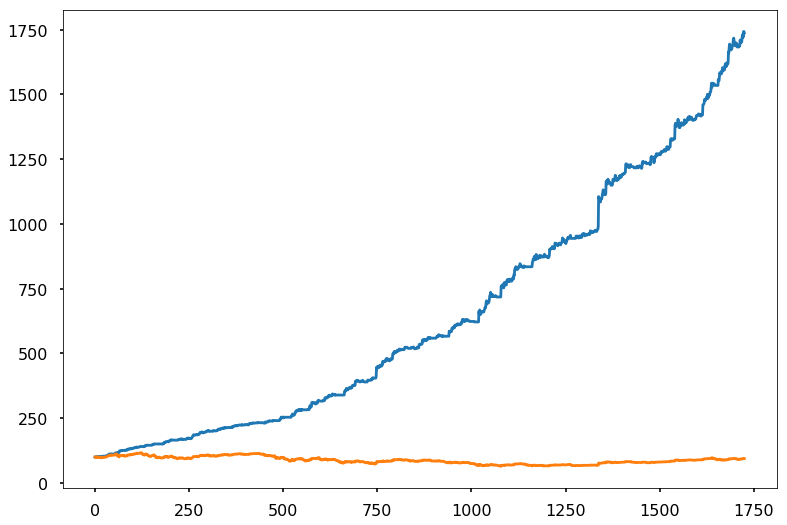

Il reste 1 algorithmes à exécuter.
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)
Aggregated results are:
Hold         : 1266
Buy          : 132
Sell         : 131
Got_cash     : 328
Fees_cost    : 335.30329466910604% of initial investment
Total_result : +1166.831964154833% from initial investment


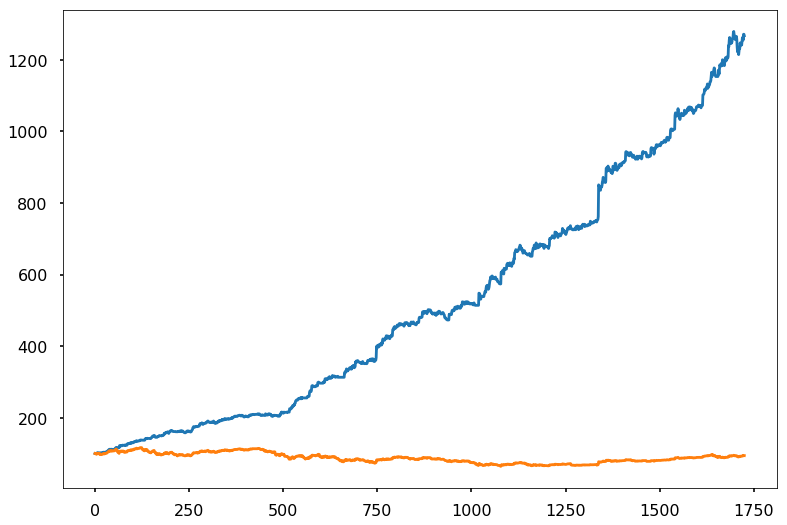

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,Gain_test,Number of transactions
5,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.666081,0.735652,1738.29,NaN
18,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.664325,0.732174,1737.54,NaN
7,RidgeClassifierCV,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': N...",0.663823,0.732174,1737.54,NaN
15,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.664827,0.735652,1706.05,NaN
19,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.627446,0.652754,1266.83,NaN
13,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.718766,0.729855,1173.13,NaN
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",1,0.724058,1024.3,NaN
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",1,0.725217,959.904,NaN
11,GaussianNB,{'priors': None},0.612142,0.628986,751.994,NaN
10,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.635223,0.681739,490.054,NaN


In [7]:
#Machine Learning Algorithm (MLA) Selection and Initialization
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(n_estimators = 500),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(n_estimators = 500),
    ensemble.GradientBoostingClassifier(n_estimators = 500),
    ensemble.RandomForestClassifier(n_estimators = 500),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(tol=1e-3, max_iter=1000),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(tol=1e-3, max_iter=1000),
    linear_model.Perceptron(tol=1e-3, max_iter=1000),
    
    #Naives Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),   
    ]

MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean','Gain_test','Number of transactions']
MLA_compare = pd.DataFrame(columns = MLA_columns)
row_index = 0

for alg in MLA:
    print('Il reste ' + str(len(MLA) - row_index) +' algorithmes à exécuter.')
    print(alg)
    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    alg.fit(X_train, y_train)
    prediction_test = alg.predict(X_test)
    for i in range(len(prediction_test)):
        if prediction_test[i] == 0:
            prediction_test[i] = -1

    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = alg.score(X_train, y_train)
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = alg.score(X_test, y_test)
    decisions_results = results.strategy_based_results(prediction_test, market_prices, fee_rate = 0.3, verbose=True)
    market_var = results.buy_hold_results(market_prices)
    
    L = [i for i in range(len(decisions_results))]

    # Results display
    plt.plot(L, decisions_results)
    plt.plot(L, market_var)
    plt.show()

    MLA_compare.loc[row_index, 'Gain_test'] = decisions_results[-1]   #let's know the worst that can happen!    
    row_index+=1
    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['Gain_test'], ascending = False)

In [8]:
# Some useful parameters which will come in handy later on
from sklearn.cross_validation import KFold
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)
#rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, params=None):
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

C:\Users\flore\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0,
    'random_state' : 19
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state' : 19
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75,
    'random_state' : 19
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state' : 19
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025,
    'random_state' : 19
    }

new_params = {
    'tol' : 1e-3,
    'max_iter' : 1000
}

random_state = {
    'random_state' : 19
}

In [10]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process


#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics


# Create 5 objects that represent our 4 models
#rf = SklearnHelper(clf=RandomForestClassifier, params=rf_params)
#et = SklearnHelper(clf=ExtraTreesClassifier, params=et_params)
#ada = SklearnHelper(clf=AdaBoostClassifier, params=ada_params)
#gb = SklearnHelper(clf=GradientBoostingClassifier, params=gb_params)
#svc = SklearnHelper(clf=SVC, params=svc_params)
#bag = SklearnHelper(clf=ensemble.BaggingClassifier, params=random_state)
#gauss = SklearnHelper(clf=gaussian_process.GaussianProcessClassifier, params=random_state)
log = SklearnHelper(clf=linear_model.LogisticRegressionCV, params=random_state)
#pasag = SklearnHelper(clf=linear_model.PassiveAggressiveClassifier, params=new_params)
ridge = SklearnHelper(clf=linear_model.RidgeClassifierCV, params={})
#SGDC = SklearnHelper(clf=linear_model.SGDClassifier, params=new_params)
#perc = SklearnHelper(clf=linear_model.Perceptron, params=new_params)
#naiveb = SklearnHelper(clf=naive_bayes.BernoulliNB, params={})
#naiveg = SklearnHelper(clf=naive_bayes.GaussianNB, params={})
#knn = SklearnHelper(clf=neighbors.KNeighborsClassifier, params={})             
svmm = SklearnHelper(clf=svm.LinearSVC, params=random_state)  
lda = SklearnHelper(clf=discriminant_analysis.LinearDiscriminantAnalysis, params={})                 
#qda = SklearnHelper(clf=discriminant_analysis.QuadraticDiscriminantAnalysis, params={})                 
#nusvc = SklearnHelper(clf=svm.NuSVC, params=random_state)



In [11]:
# Create our OOF train and test predictions. These base results will be used as new features
#et_oof_train, et_oof_test = get_oof(et, X_train, y_train, X_test) # Extra Trees
#rf_oof_train, rf_oof_test = get_oof(rf,X_train, y_train, X_test) # Random Forest
#ada_oof_train, ada_oof_test = get_oof(ada, X_train, y_train, X_test) # AdaBoost 
#gb_oof_train, gb_oof_test = get_oof(gb,X_train, y_train, X_test) # Gradient Boost
#svc_oof_train, svc_oof_test = get_oof(svc,X_train, y_train, X_test) # Support Vector Classifier
#bag_oof_train, bag_oof_test = get_oof(bag,X_train, y_train, X_test)
#gauss_oof_train, gauss_oof_test = get_oof(gauss,X_train, y_train, X_test)
log_oof_train, log_oof_test = get_oof(log,X_train, y_train, X_test)
#pasag_oof_train, pasag_oof_test = get_oof(pasag,X_train, y_train, X_test)
ridge_oof_train, ridge_oof_test = get_oof(ridge,X_train, y_train, X_test)
#SGDC_oof_train, SGDC_oof_test = get_oof(SGDC,X_train, y_train, X_test)
#perc_oof_train, perc_oof_test = get_oof(perc,X_train, y_train, X_test)
#naiveb_oof_train, naiveb_oof_test = get_oof(naiveb,X_train, y_train, X_test)
#naiveg_oof_train, naiveg_oof_test = get_oof(naiveg,X_train, y_train, X_test)
#knn_oof_train, knn_oof_test = get_oof(knn,X_train, y_train, X_test)
#nusvc_oof_train, nusvc_oof_test = get_oof(nusvc,X_train, y_train, X_test)
svmm_oof_train, svmm_oof_test = get_oof(svmm,X_train, y_train, X_test)
lda_oof_train, lda_oof_test = get_oof(lda,X_train, y_train, X_test)
#qda_oof_train, qda_oof_test = get_oof(qda,X_train, y_train, X_test)

In [12]:
#X_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train,
#                         bag_oof_train, gauss_oof_train, log_oof_train, pasag_oof_train, ridge_oof_train,
#                         SGDC_oof_train, perc_oof_train, naiveb_oof_train, naiveg_oof_train,
#                         knn_oof_train, nusvc_oof_train, svmm_oof_train, lda_oof_train, qda_oof_train), axis=1)
#pred_train_df = pd.DataFrame({'extra trees': et_oof_train.ravel(),
#                              'random forest': rf_oof_train.ravel(),
#                              'ada boost': ada_oof_train.ravel(),
#                              'gradient boosting': gb_oof_train.ravel(),
#                              'svc': svc_oof_train.ravel(),
#                              'bagging': bag_oof_train.ravel(),
#                              'gaussian': gauss_oof_train.ravel(),
#                              'reg log': log_oof_train.ravel(),
#                              'passiv aggressiv': pasag_oof_train.ravel(),
#                              'ridge': ridge_oof_train.ravel(),
#                              'SGDC': SGDC_oof_train.ravel(),
#                              'perceptron': perc_oof_train.ravel(),
#                              'naiveb': naiveb_oof_train.ravel(),
#                              'naiveg': naiveg_oof_train.ravel(),
#                              'knn': knn_oof_train.ravel(),
#                              'nusvc': nusvc_oof_train.ravel(),
#                              'svmm': svmm_oof_train.ravel(),
#                              'lda': lda_oof_train.ravel(),
#                              'qda': qda_oof_train.ravel(),
#                             })
#colormap = plt.cm.RdBu
#plt.figure(figsize=(24,20))
#plt.title('Pearson Correlation of Features', y=1.05, size=15)
#sns.heatmap(pred_train_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
#            square=True, cmap=colormap, linecolor='white', annot=True)
#plt.show()
#X_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test,
#                         bag_oof_test, gauss_oof_test, log_oof_test, pasag_oof_test, ridge_oof_test,
#                         SGDC_oof_test, perc_oof_test, naiveb_oof_test, naiveg_oof_test,
#                         knn_oof_test, nusvc_oof_test, svmm_oof_test, lda_oof_test, qda_oof_test), axis=1)
#

In [13]:
#X_train = np.concatenate((rf_oof_train, ada_oof_train, gb_oof_train,
#                         bag_oof_train, gauss_oof_train, log_oof_train, pasag_oof_train,
#                         SGDC_oof_train, perc_oof_train, naiveg_oof_train,
#                         knn_oof_train, lda_oof_train, ), axis=1)
#
#X_test = np.concatenate((rf_oof_test, ada_oof_test, gb_oof_test,
#                         bag_oof_test, gauss_oof_test, log_oof_test, pasag_oof_test,
#                         SGDC_oof_test, perc_oof_test, naiveg_oof_test,
#                         knn_oof_test, lda_oof_test), axis=1)


X_train = np.concatenate((log_oof_train, ridge_oof_train, svmm_oof_train,
                         lda_oof_train,), axis=1)
X_test = np.concatenate((log_oof_test, ridge_oof_test, svmm_oof_test,
                         lda_oof_test,), axis=1)

In [14]:
#Machine Learning Algorithm (MLA) Selection and Initialization
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process


#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(n_estimators = 500),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(n_estimators = 500),
    ensemble.GradientBoostingClassifier(n_estimators = 500),
    ensemble.RandomForestClassifier(n_estimators = 500),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(tol=1e-3, max_iter=1000),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(tol=1e-3, max_iter=1000),
    linear_model.Perceptron(tol=1e-3, max_iter=1000),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),   
    ]
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'Gain_test']
MLA_compare = pd.DataFrame(columns = MLA_columns)
row_index = 0
for alg in MLA:
    print('Il reste ' + str(len(MLA) - row_index) +' algorithmes à exécuter.')
    print(alg)
    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    alg.fit(X_train, y_train)
    prediction_test = alg.predict(X_test)
    for i in range(len(prediction_test)):
        if prediction_test[i] ==0:
            prediction_test[i] = -1

    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = alg.score(X_train, y_train)
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = alg.score(X_test, y_test)
    decisions_results = results.strategy_based_results(prediction_test, market_prices, fee_rate = 0.3, verbose=True)
    
    MLA_compare.loc[row_index, 'Gain_test'] = decisions_results[-1]   #let's know the worst that can happen!    
    row_index+=1
    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['Gain_test'], ascending = False)

Il reste 21 algorithmes à exécuter.
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=500, random_state=None)
Aggregated results are:
Hold         : 965
Buy          : 163
Sell         : 162
Got_cash     : 598
Fees_cost    : 536.5589631392362% of initial investment
Total_result : +1551.6556493285818% from initial investment
Il reste 20 algorithmes à exécuter.
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)
Aggregated results are:
Hold         : 965
Buy          : 163
Sell         : 162
Got_cash     : 598
Fees_cost    : 536.5589631392362% of initial investment
Total_result : +1551.6556493285818% from initial investment
Il reste 19 algorithmes à exécuter.
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=No

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,Gain_test
20,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.653287,0.735652,1710.13
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.652032,0.728696,1698.97
19,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.653287,0.734493,1692.46
8,RidgeClassifierCV,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': N...",0.652032,0.734493,1692.46
16,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.653287,0.734493,1692.46
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.654541,0.736232,1687.56
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.654541,0.736232,1687.56
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.654541,0.736232,1687.56
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.65429,0.733333,1686.04
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.653537,0.733913,1676.3
